## 使用SKLearn库实现

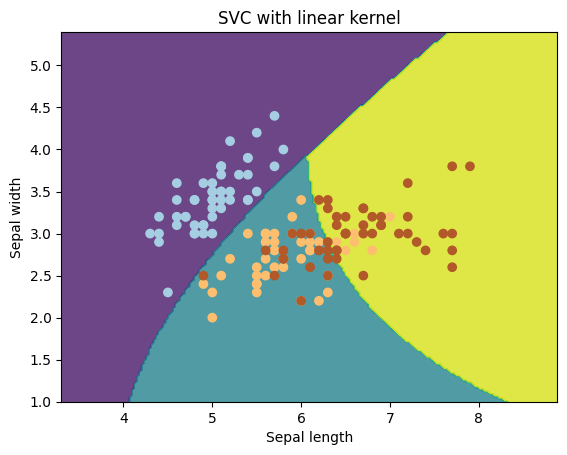

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
iris = datasets.load_iris()
X = iris.data[:, :2]  # 只取前两维特征，方便可视化
y = iris.target
svc = svm.SVC(kernel='poly', C=1).fit(X, y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max / x_min) / 100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.subplot(1, 1, 1)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
plt.show()

In [17]:
import plotly.graph_objects as go

fig3d = go.Figure(data=[go.Surface(x=xx, y=yy, z=Z),
                        go.Scatter3d(x=X[:, 0], y=X[:, 1], z=y),
                        ])
fig3d.update_layout(scene=dict(
    xaxis_title='Sepal length',
    yaxis_title='Sepal width',
    zaxis_title='Class'
))
fig3d.show()

## 手动实现支持向量机

In [18]:
import cvxopt

仅使用前两个类别(0和1)的数据进行二分类

In [19]:
mask = (y < 2)
X_fit = X[mask]
y_fit = y[mask].astype(np.float64)
y_fit[y_fit == 0] = -1.0  # 将标签0调整为-1
m, n = X_fit.shape

构造二次规划问题

In [20]:
# 构造QP需要的矩阵
# min 1/2 x^T P x + q^T x
# subject to Gx <= h, Ax = b
K = np.outer(y_fit, y_fit) * (X_fit @ X_fit.T)
P = cvxopt.matrix(K, tc='d')
q = cvxopt.matrix(-np.ones(m), tc='d')
G = cvxopt.matrix(-np.eye(m), tc='d')
h = cvxopt.matrix(np.zeros(m), tc='d')
A = cvxopt.matrix(y_fit, (1, m), tc='d')
b = cvxopt.matrix(0.0)

In [21]:
solution = cvxopt.solvers.qp(P, q, G, h, A, b)
alphas = np.ravel(solution['x'])
# 计算w和b
w = ((alphas * y_fit)[:, None] * X_fit).sum(axis=0)
mask_sv = alphas > 1e-5
b = np.mean(y_fit[mask_sv] - X_fit[mask_sv] @ w)

print("w:", w)
print("b:", b)

     pcost       dcost       gap    pres   dres
 0: -1.7589e+01 -3.8372e+01  3e+02  2e+01  2e+00
 1: -3.0327e+01 -3.6084e+01  1e+02  6e+00  7e-01
 2: -5.7223e+01 -5.3982e+01  1e+02  4e+00  5e-01
 3: -4.3062e+01 -4.2587e+01  5e+01  1e+00  2e-01
 4: -3.3934e+01 -3.4338e+01  4e+00  9e-02  1e-02
 5: -3.3794e+01 -3.3801e+01  4e-02  1e-03  1e-04
 6: -3.3795e+01 -3.3795e+01  4e-04  1e-05  1e-06
 7: -3.3795e+01 -3.3795e+01  4e-06  1e-07  1e-08
Optimal solution found.
w: [ 6.31578946 -5.26315788]
b: -17.315789437864257


已经找到了w和b，只需要带入wx+b的公式，判断正负即可。